In [1]:
#copy/paste the packages for this week

#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

D:\computation\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# load my corpus of interest - All New York Times articles published '80-'89 that mention Vietnam
nyt80s = pandas.read_csv('../data/nyt80s.csv')

# prepare

nyt80s['tokenized_words'] = nyt80s['article'].apply(lambda x: nltk.word_tokenize(x))
nyt80s['normalized_words'] = nyt80s['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [3]:
#create a docID column for easy tagging and retrieval
nyt80s["docID"] = nyt80s.index

In [4]:
keywords = ['missing', 'war', 'prisoner', 'captivity', 'nixon', 'reagan']

In [5]:
taggedArticles = []
for index, row in nyt80s.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['date'])
    docKeywords.append(row['docID']) #This lets us extract individual documents
    taggedArticles.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
nyt80s['TaggedArticles'] = taggedArticles

In [6]:
nytD2V = gensim.models.doc2vec.Doc2Vec(nyt80s['TaggedArticles'], size = 100) #Limiting to 100 dimensions

In [7]:
nytD2V.most_similar(positive = ['missing','servicemen'], negative = ['nixon'], topn = 1)

[('unaccounted', 0.6080336570739746)]

In [8]:
nytD2V.most_similar(positive = ['missing','servicemen'], negative = ['carter'], topn = 1)

[('unaccounted', 0.6565977931022644)]

In [9]:
nytD2V.most_similar(positive = ['missing','servicemen'], negative = ['reagan'], topn = 1)

[('unaccounted', 0.6788337230682373)]

In [10]:
nytD2V.most_similar(positive = ['missing','servicemen', 'nixon'])

[('unaccounted', 0.7960089445114136),
 ('captives', 0.6968147158622742),
 ('hostages', 0.6881918907165527),
 ('captivity', 0.6724515557289124),
 ('rescues', 0.6660469770431519),
 ('captive', 0.6635831594467163),
 ('prisoners', 0.649223804473877),
 ('dead', 0.6269862651824951),
 ('amerasians', 0.61726975440979),
 ('hostage', 0.6162548065185547)]

In [11]:
nytD2V.most_similar(positive = ['missing','servicemen', 'reagan'])

[('unaccounted', 0.7356752157211304),
 ('captives', 0.6801637411117554),
 ('hostages', 0.6637107133865356),
 ('rescues', 0.6444711089134216),
 ('captive', 0.6258302927017212),
 ('dead', 0.6165148019790649),
 ('captivity', 0.6071785092353821),
 ('prisoners', 0.5909515619277954),
 ('hostage', 0.5881564617156982),
 ('amerasians', 0.5774591565132141)]

In [12]:
nytD2V.docvecs.most_similar([ nytD2V['captivity'] ], topn=5 )

[(4725, 0.6938217878341675),
 (1128, 0.6776479482650757),
 (963, 0.6662752628326416),
 (2239, 0.6632021069526672),
 ('October 6 1983 ', 0.6539720892906189)]

In [13]:
# let's see what the most similar article looks like

#print(nyt80s['date']['October 6 1983'])

nyt80s.loc[1128]['article']

"    The 52 Americans held 444 days in Iran were not the only hostages involved in that crisis.  Their wives, children, parents and other relatives also found themselves held captive by the incident, trapped on what one called ''an emotional roller coaster of hope and despair,'' never knowing when or how the terrifying ride might end.  Today, finally, their ordeal will end, and all those yellow ribbons tied around trees from coast to coast will come down in a burst of euphoria. But scars and bitter memories will surely remain after the families and their loved ones are reunited around midday in an airport hangar near Newburgh, N.Y. For most relatives of the former hostages, the past 15 months add up to the worst experience of their lives.  ''I think the families will have as long a healing and recovery process as the hostages themselves in some cases,'' said Helen McLellan, the sister of Joseph M. Hall, a military attache, as relatives began packing for the trip to West Point.  The hos

In [14]:
# let's see what words are most similar to this document

nytD2V.most_similar( [ nytD2V.docvecs[1128] ], topn=5) 

[('thiep', 0.750247061252594),
 ('distraught', 0.7476983070373535),
 ('honorably', 0.7334441542625427),
 ('partitioned', 0.7279917001724243),
 ('freed', 0.7198662757873535)]

In [15]:
# let's find documens most similar to a combination 

nytD2V.docvecs.most_similar([ nytD2V['missing']+nytD2V['servicemen']+nytD2V['captivity']], topn=5 )

[(7158, 0.7036421298980713),
 (8142, 0.6893575191497803),
 ('January 22 1986 ', 0.6883097887039185),
 (10467, 0.666242778301239),
 (4725, 0.66390061378479)]

In [16]:
# let's print out the top one and see what the article has to say

nyt80s.loc[8142]['article']

"      Three members of Congress criticized Vietnam and Laos today for rejecting a suggestion that an international team be sent to investigate reports that American servicemen have been seen alive in the two countries since the release of prisoners in 1973.  The Congressmen - Senator Frank H. Murkowski, Republican of Alaska who is chairman of the Senate Veterans Affairs Committee, Senator Dennis DeConcini, Democrat of Arizona, and Representative Bob McEwen, Republican of Ohio - recently returned from a trip to Indochina and appeared today at a news conference. ''We made the point that if you have nothing to hide, open the books,'' Mr. McEwen said.  Senator Murkowski said the delegation returned without any indication that American prisoners remained there, but he endorsed the Reagan Administration's refusal to rule out the possibility.  Vietnam denies it holds Americans.  LANGUAGE: ENGLISH                      "

In [17]:
nyt80s.loc[4434]['article']

"      Defense Secretary Caspar W. Weinberger today ordered that a special plaque honoring the country's Vietnam War dead be placed at the Tomb of the Unknown Soldier, where there is still an empty crypt. The plaque will be dedicated on Memorial Day, the Pentagon said.  Mr. Weinberger also ordered a second plaque placed at the Arlington National Cemetery Memorial Amphitheater to explain that ''interment of a Vietnam war unknown is impossible now because the remains of Americans who died in Southeast Asia are still being identified,'' the Pentagon said.  More than 10 years after American forces were pulled out of the Southeast Asia war, Army technicians at a special laboratory in Hawaii are still trying to identify three sets of remains.  LANGUAGE: ENGLISH                      "

In [18]:
# What does a heatmap tell us?

heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nytD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nytD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

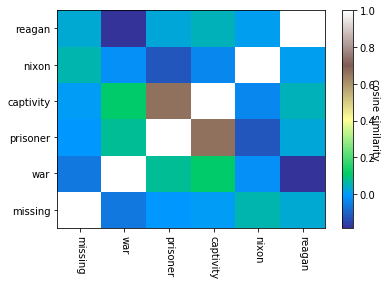

In [19]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

In [20]:
targetDocs = nyt80s['docID'][:25]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = nytD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nytD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

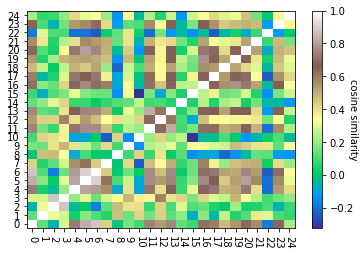

In [21]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [22]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = nytD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nytD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

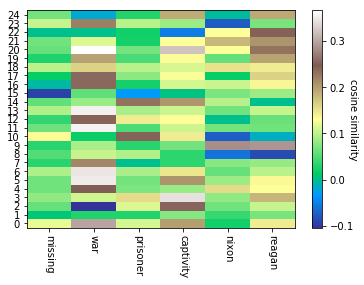

In [23]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)